<a href="https://www.kaggle.com/code/aliknot/facial-emotion-recognition-using-repvgg?scriptVersionId=236485017" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/aliknot/facial-emotion-recognitions?scriptVersionId=232682889" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Emotion detection in Facial Recognition

## Clone GitHub Repositories

In [32]:
!git clone https://github.com/aliknot/facial-emotion-recognition

fatal: destination path 'facial-emotion-recognition' already exists and is not an empty directory.


In [33]:
!git clone https://github.com/DingXiaoH/RepVGG

fatal: destination path 'RepVGG' already exists and is not an empty directory.


## Install Essential Libraries

In [34]:
!pip install mtcnn

## Import Necessary Libraries

In [35]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from mtcnn import MTCNN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

## Global Variables

In [36]:
output_base_url = '/kaggle/working/'
repo_base_url = os.path.join(output_base_url, 'facial-emotion-recognition')
images_url = os.path.join(repo_base_url, 'images')

repvgg_url = os.path.join(output_base_url, 'RepVGG')
organized_images_url = os.path.join(output_base_url, 'images_organized')
cropped_images_url = os.path.join(output_base_url, 'cropped_images')
resized_images_url = os.path.join(output_base_url, 'resized_images')
normalized_images_url = os.path.join(output_base_url, 'normalized_images')
augmented_images_url = os.path.join(output_base_url, 'augmented_images')
splitted_images_url = os.path.join(output_base_url, 'splitted_images')

In [37]:
# List of emotions
emotions = ['Happy', 'Neutral', 'Sad', 'Surprised', 'Disgust', 'Anger', 'Fear', 'Contempt']

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Organize the photos in emotions folders

In [39]:
if not os.path.exists(organized_images_url):
    os.makedirs(organized_images_url)
    
# Iterate through each numbered folder (0-18)
for folder_name in sorted(os.listdir(images_url)):
    folder_path = os.path.join(images_url, folder_name)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            
            if os.path.isfile(img_path):  # Ensure it's a file
                emotion_label = img_file.split('.')[0]  # Extract the emotion label
                
                if emotion_label in emotions:
                    destination_folder = os.path.join(organized_images_url, emotion_label)
                    if not os.path.exists(destination_folder):
                        os.makedirs(destination_folder)
                    
                    # Rename the image with folder name to avoid duplicates
                    new_img_name = f"{folder_name}_{img_file}"
                    destination_path = os.path.join(destination_folder, new_img_name)
                    
                    shutil.copy(img_path, destination_path)  # Copy instead of move
                    print(f"Copied {img_file} to {destination_path}")

print("Dataset successfully organized!")

Copied Neutral.jpg to /kaggle/working/images_organized/Neutral/0_Neutral.jpg
Copied Surprised.jpg to /kaggle/working/images_organized/Surprised/0_Surprised.jpg
Copied Fear.jpg to /kaggle/working/images_organized/Fear/0_Fear.jpg
Copied Happy.jpg to /kaggle/working/images_organized/Happy/0_Happy.jpg
Copied Contempt.jpg to /kaggle/working/images_organized/Contempt/0_Contempt.jpg
Copied Anger.jpg to /kaggle/working/images_organized/Anger/0_Anger.jpg
Copied Disgust.jpg to /kaggle/working/images_organized/Disgust/0_Disgust.jpg
Copied Sad.jpg to /kaggle/working/images_organized/Sad/0_Sad.jpg
Copied Neutral.jpg to /kaggle/working/images_organized/Neutral/1_Neutral.jpg
Copied Surprised.jpg to /kaggle/working/images_organized/Surprised/1_Surprised.jpg
Copied Fear.jpg to /kaggle/working/images_organized/Fear/1_Fear.jpg
Copied Happy.jpg to /kaggle/working/images_organized/Happy/1_Happy.jpg
Copied Contempt.jpg to /kaggle/working/images_organized/Contempt/1_Contempt.jpg
Copied Anger.jpg to /kaggle/w

## Put the organized dataset in df

In [40]:
# Initialize an empty list to store data
data = []

# Iterate over emotion folders
for emotion in emotions:
    folder_path = os.path.join(organized_images_url, emotion)
    if os.path.exists(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith('.jpg'):
                image_path = os.path.join(folder_path, file_name)
                folder_name = file_name.split('_')[0]  # Extracting folder number from filename
                
                data.append({
                    'image_path': image_path,
                    'emotion': emotion,
                    'folder': folder_name
                })

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()

,image_path,emotion,folder
0,/kaggle/working/images_organized/Happy/4_Happy...,Happy,4
1,/kaggle/working/images_organized/Happy/0_Happy...,Happy,0
2,/kaggle/working/images_organized/Happy/10_Happ...,Happy,10
3,/kaggle/working/images_organized/Happy/11_Happ...,Happy,11
4,/kaggle/working/images_organized/Happy/16_Happ...,Happy,16


## Visualize all of the imgaes per emotion

In [41]:
"""
# Count number of images per emotion
emotion_counts = df['emotion'].value_counts()

# Plot the data
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis", hue=emotion_counts.index, legend=False)

# Formatting
plt.title("Number of Images per Emotion", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
"""

'\n# Count number of images per emotion\nemotion_counts = df[\'emotion\'].value_counts()\n\n# Plot the data\nplt.figure(figsize=(10, 5))\nsns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis", hue=emotion_counts.index, legend=False)\n\n# Formatting\nplt.title("Number of Images per Emotion", fontsize=14)\nplt.xlabel("Emotion", fontsize=12)\nplt.ylabel("Number of Images", fontsize=12)\nplt.xticks(rotation=45)\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\n\n# Show the plot\nplt.show()\n'

## Crop all of the images, focusing on the face

In [42]:
# Initialize MTCNN detector
detector = MTCNN(device = 'GPU')

# Check if the the images are already cropped or not
if not os.path.exists(cropped_images_url):
    os.makedirs(cropped_images_url)
    
    # Process each emotion folder
    for emotion in emotions:
        emotion_folder = os.path.join(organized_images_url, emotion)
        cropped_emotion_folder = os.path.join(cropped_images_url, emotion)
        
        os.makedirs(cropped_emotion_folder, exist_ok=True)
    
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            image = cv2.imread(img_path)
    
            if image is None:
                print(f"Skipping {img_name}, not a valid image.")
                continue
    
            # Convert image to RGB for MTCNN
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
            # Detect faces
            detections = detector.detect_faces(image_rgb)
    
            if len(detections) == 0:
                print(f"No face detected in {img_name}, skipping...")
                continue
    
            # Get the bounding box of the first detected face
            x, y, w, h = detections[0]['box']
            cropped_face = image[y:y+h, x:x+w]
    
            # Save cropped image
            cropped_img_path = os.path.join(cropped_emotion_folder, img_name)
            cv2.imwrite(cropped_img_path, cropped_face)
            print("Cropped the image", img_name, emotion)

    print("Face cropping completed!")
else:
    print("Images are already cropped!")

Images are already cropped!


## Resize Images

In [43]:
# Target size for RepVGG
target_size = (224, 224)

# Check if the the images are already resized or not
if not os.path.exists(resized_images_url):
    os.makedirs(resized_images_url)
    
    # Process each emotion folder
    for emotion in emotions:
        emotion_folder = os.path.join(cropped_images_url, emotion)
        resized_emotion_folder = os.path.join(resized_images_url, emotion)
        
        os.makedirs(resized_emotion_folder, exist_ok=True)
    
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            image = cv2.imread(img_path)
    
            if image is None:
                print(f"Skipping {img_name}, not a valid image.")
                continue
    
            # Resize the image
            resized_image = cv2.resize(image, target_size)
    
            # Save the resized image
            resized_img_path = os.path.join(resized_emotion_folder, img_name)
            cv2.imwrite(resized_img_path, resized_image)

    print("Image resizing completed! All images are now 224x224.")
else:
    print("Images are already resized!")

Images are already resized!


## Normalize Images

In [44]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define a transform to convert images to tensors without normalization
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the dataset and dataloader
dataset = ImageDataset(image_dir=resized_images_url, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Function to calculate mean and std
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(dataloader)
print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: tensor([0.6104, 0.4769, 0.4438])
Calculated Std: tensor([0.1794, 0.1767, 0.1775])


In [45]:
# Define the normalization transform
normalize = transforms.Normalize(mean=mean, std=std)

# Define the complete transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

# Remove the directory if it exists to avoid duplicates
if os.path.exists(normalized_images_url):
    shutil.rmtree(normalized_images_url)
os.makedirs(normalized_images_url)

# Normalize and save images
for img_rel_path in dataset.image_paths:
    img = Image.open(img_rel_path).convert('RGB')
    img_tensor = transform(img)
    # Convert tensor back to PIL Image
    img_normalized = transforms.ToPILImage()(img_tensor)
    # Define the path to save the normalized image
    relative_path = os.path.relpath(img_rel_path, resized_images_url)
    save_path = os.path.join(normalized_images_url, relative_path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    img_normalized.save(save_path)

print("All images have been normalized and saved.")

All images have been normalized and saved.


## Data Augmentation

In [46]:
import os
from PIL import Image
from torchvision import transforms
import torch

data_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
])

# Number of augmented images to generate per original image
num_augmented_images = 50

# Iterate over each emotion category
for emotion in os.listdir(normalized_images_url):
    emotion_dir = os.path.join(normalized_images_url, emotion)
    if not os.path.isdir(emotion_dir):
        continue

    # Create corresponding directory in the output folder
    output_emotion_dir = os.path.join(augmented_images_url, emotion)
    os.makedirs(output_emotion_dir, exist_ok=True)

    # Process each image in the current emotion directory
    for img_name in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_name)
        if not os.path.isfile(img_path):
            continue

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Generate augmented images
        for i in range(num_augmented_images):
            augmented_image = data_augmentation(image)
            augmented_image_pil = transforms.ToPILImage()(augmented_image)

            # Save the augmented image
            base_name, ext = os.path.splitext(img_name)
            augmented_img_name = f"{base_name}_aug_{i}{ext}"
            augmented_img_path = os.path.join(output_emotion_dir, augmented_img_name)
            augmented_image_pil.save(augmented_img_path)

print("Data augmentation complete. Augmented images are saved in:", augmented_images_url)

Data augmentation complete. Augmented images are saved in: /kaggle/working/augmented_images


## Split the Dataset

In [47]:
import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [48]:
# Define paths
train_dir = os.path.join(splitted_images_url, 'train')
val_dir = os.path.join(splitted_images_url, 'val')
test_dir = os.path.join(splitted_images_url, 'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

# Iterate and split
for class_name in os.listdir(augmented_images_url):
    class_dir = os.path.join(augmented_images_url, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        random.shuffle(images)
        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        paths = {
            'train': os.path.join(train_dir, class_name),
            'val': os.path.join(val_dir, class_name),
            'test': os.path.join(test_dir, class_name)
        }

        for path in paths.values():
            os.makedirs(path, exist_ok=True)

        for i, image in enumerate(images):
            src = os.path.join(class_dir, image)
            if i < train_end:
                dst = os.path.join(paths['train'], image)
            elif i < val_end:
                dst = os.path.join(paths['val'], image)
            else:
                dst = os.path.join(paths['test'], image)
            shutil.copyfile(src, dst)

print("Dataset successfully split.")

Dataset successfully split.


## Model

In [63]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define paths
train_dir = os.path.join(splitted_images_url, 'train')
val_dir = os.path.join(splitted_images_url, 'val')
test_dir = os.path.join(splitted_images_url, 'test')

# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
    # No normalization, because your images are already normalized
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [64]:
import importlib.util
import sys

# Load se_block.py first
se_block_path = '/kaggle/working/RepVGG/se_block.py'
se_spec = importlib.util.spec_from_file_location("se_block", se_block_path)
se_block = importlib.util.module_from_spec(se_spec)
sys.modules["se_block"] = se_block
se_spec.loader.exec_module(se_block)

# Now load repvgg.py (it depends on se_block being loaded first)
repvgg_path = '/kaggle/working/RepVGG/repvgg.py'
repvgg_spec = importlib.util.spec_from_file_location("repvgg", repvgg_path)
repvgg = importlib.util.module_from_spec(repvgg_spec)
sys.modules["repvgg"] = repvgg
repvgg_spec.loader.exec_module(repvgg)

# Example use:
model = repvgg.create_RepVGG_A0()

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =

In [65]:
import torch
import torch.nn as nn

# Use the dynamically imported module from earlier
model = repvgg.create_RepVGG_A0(deploy=False)

# Load pretrained weights (assuming this file is already in your working directory)
checkpoint = torch.load('/kaggle/working/facial-emotion-recognition/RepVGG-A0-train.pth')

# You may need to set strict=False if fine-tuning:
model.load_state_dict(checkpoint, strict=False)

# Modify the classifier to match the number of classes
num_classes = len(train_dataset.classes)
model.linear = nn.Linear(model.linear.in_features, num_classes)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =

<ipython-input-65-63d03b46e68f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/facial-emotion-recognition/RepVGG-A0-train.pth')


In [53]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [66]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early stopping
early_stopper = EarlyStopping(patience=10, min_delta=0.001)

# For saving the best model
best_val_acc = 0.0
best_model_path = "face-emotion-recognizer-model.pth"

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # 📉 Step scheduler
    scheduler.step(epoch_val_loss)

    # 💾 Save best model
    if epoch_val_accuracy > best_val_acc:
        best_val_acc = epoch_val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"📌 Best model saved at Epoch {epoch+1} with Val Acc: {best_val_acc:.2f}%")

    # 🛑 Early stopping
    if early_stopper(epoch_val_loss):
        print("🛑 Early stopping triggered.")
        break

    # 📊 Print
    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")
    print(f"📉 Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📌 Best model saved at Epoch 1 with Val Acc: 52.09%
Epoch 1/50 — Train Loss: 1.3400, Train Acc: 50.97% | Val Loss: 1.5318, Val Acc: 52.09%
📉 Current Learning Rate: 0.001000
📌 Best model saved at Epoch 2 with Val Acc: 85.29%
Epoch 2/50 — Train Loss: 0.4130, Train Acc: 85.76% | Val Loss: 0.4283, Val Acc: 85.29%
📉 Current Learning Rate: 0.001000
Epoch 3/50 — Train Loss: 0.1684, Train Acc: 94.59% | Val Loss: 0.5006, Val Acc: 83.53%
📉 Current Learning Rate: 0.001000
Epoch 4/50 — Train Loss: 0.1605, Train Acc: 94.54% | Val Loss: 0.7111, Val Acc: 78.56%
📉 Current Learning Rate: 0.001000
📌 Best model saved at Epoch 5 with Val Acc: 90.72%
Epoch 5/50 — Train Loss: 0.1184, Train Acc: 96.28% | Val Loss: 0.2852, Val Acc: 90.72%
📉 Current Learning Rate: 0.001000
Epoch 6/50 — Train Loss: 0.1300, Train Acc: 95.51% | Val Loss: 0.6966, Val Acc: 81.63%
📉 Current Learning Rate: 0.001000
📌 Best model saved at Epoch 7 with Val Acc: 93.79%
Epoch 7/50 — Train Loss: 0.0816, Train Acc: 97.29% | Val Loss: 0.1753,

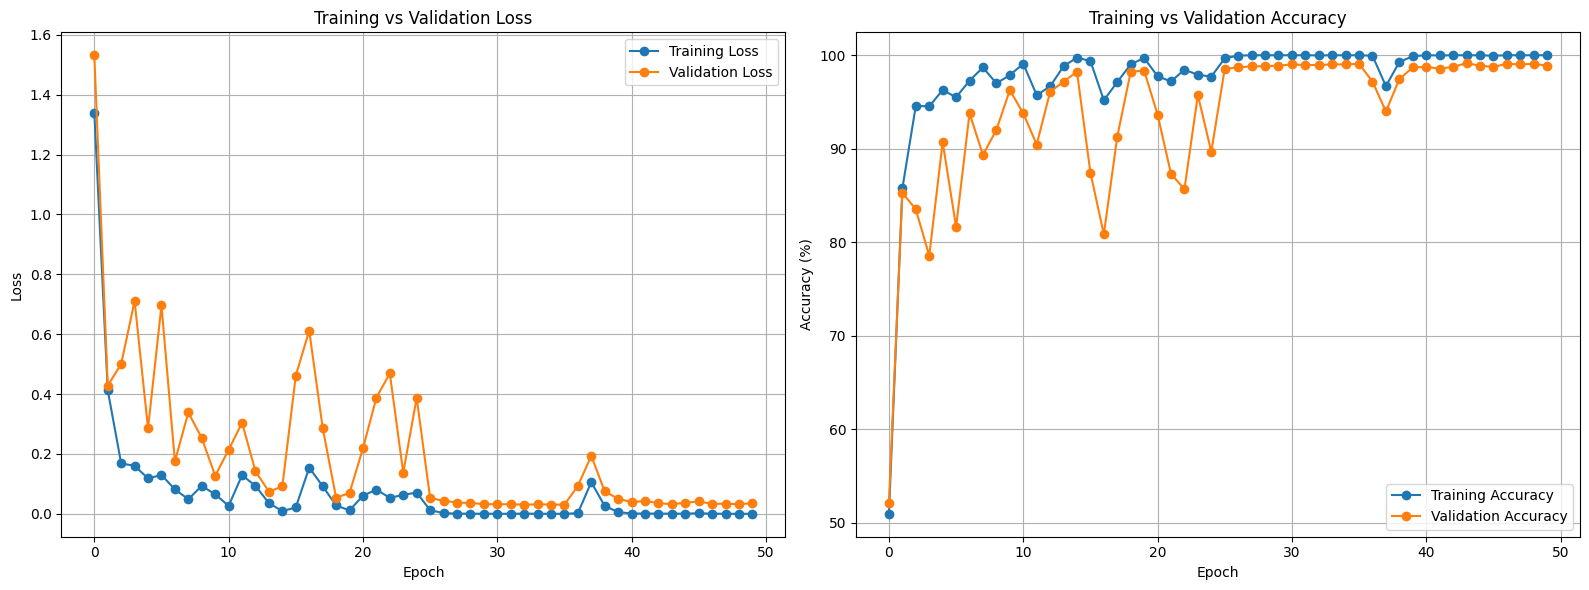

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [68]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%")

Test Loss: 0.025767064093543013, Accuracy: 99.54218443427077%


In [69]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = test_dataset.classes

In [71]:
print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

📊 Classification Report:

              precision    recall  f1-score   support

       Anger       0.98      0.98      0.98       191
    Contempt       1.00      1.00      1.00       193
     Disgust       1.00      1.00      1.00       196
        Fear       1.00      1.00      1.00       187
       Happy       0.98      0.98      0.98       192
     Neutral       1.00      1.00      1.00       191
         Sad       1.00      0.99      1.00       187
   Surprised       1.00      1.00      1.00       192

    accuracy                           1.00      1529
   macro avg       1.00      1.00      1.00      1529
weighted avg       1.00      1.00      1.00      1529



In [72]:
import pandas as pd

cm = confusion_matrix(all_labels, all_preds)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
df_accuracy = pd.DataFrame({
    'Class': class_names,
    'Accuracy (%)': (class_accuracy * 100).round(2)
})
print("✅ Per-Class Accuracy:\n")
print(df_accuracy)

✅ Per-Class Accuracy:

       Class  Accuracy (%)
0      Anger         98.43
1   Contempt        100.00
2    Disgust        100.00
3       Fear        100.00
4      Happy         98.44
5    Neutral        100.00
6        Sad         99.47
7  Surprised        100.00


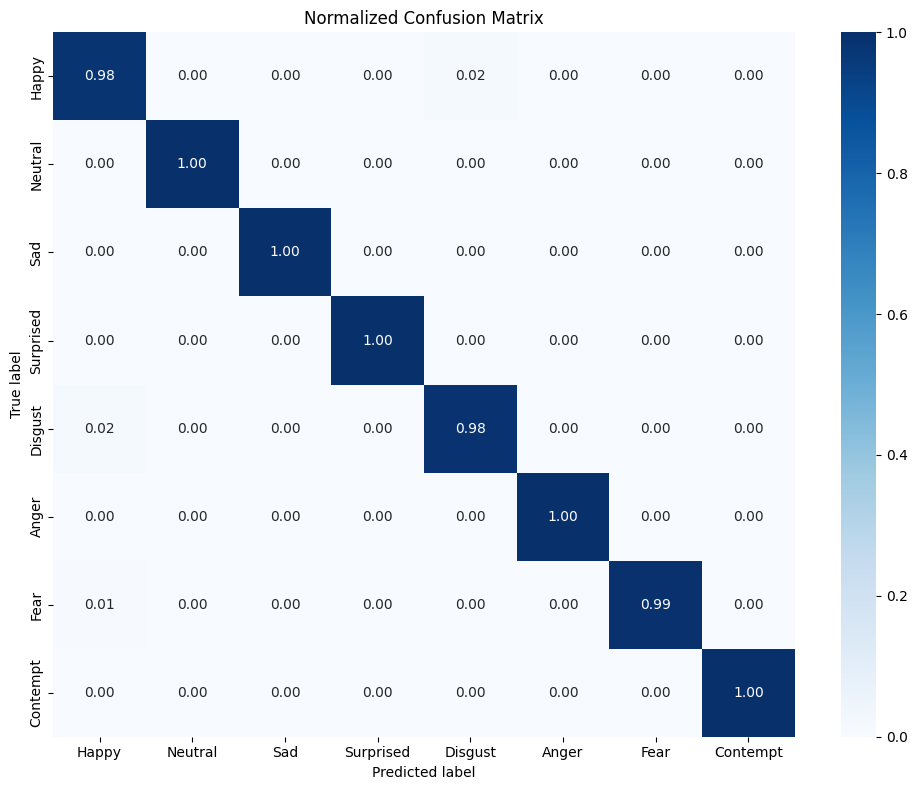

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=emotions, yticklabels=emotions)

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()